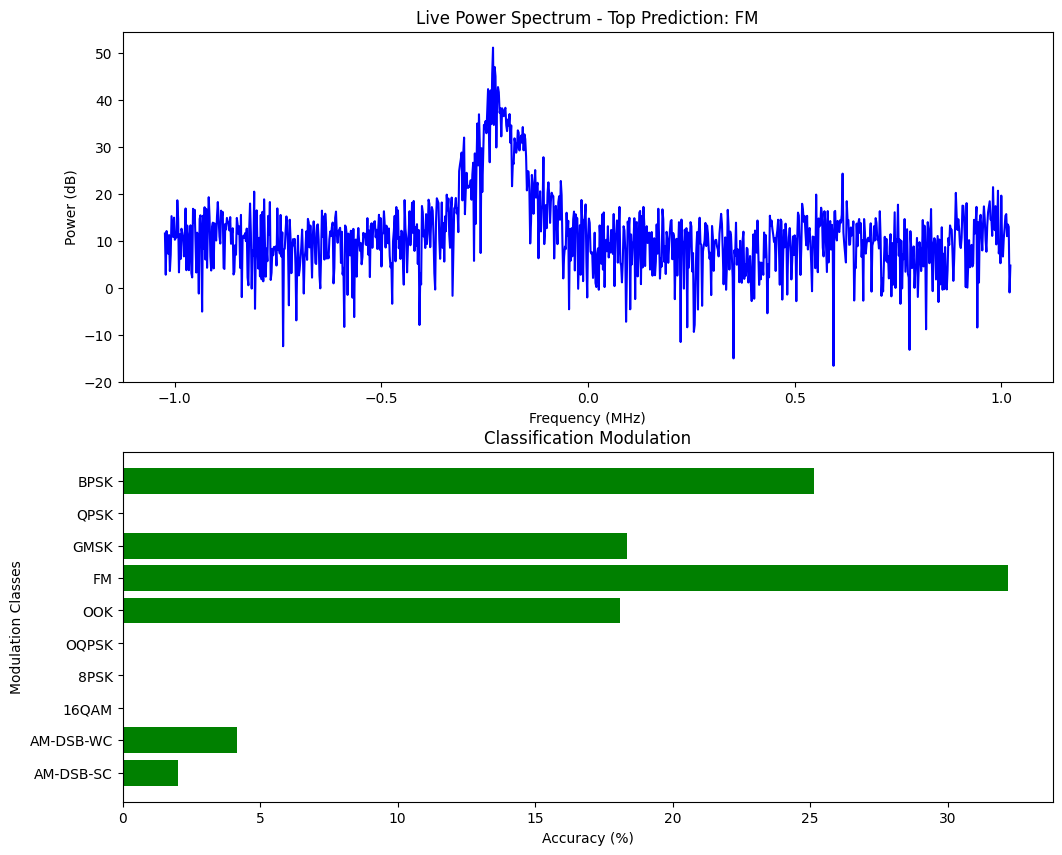


Stopping RTL-SDR and closing inference session.


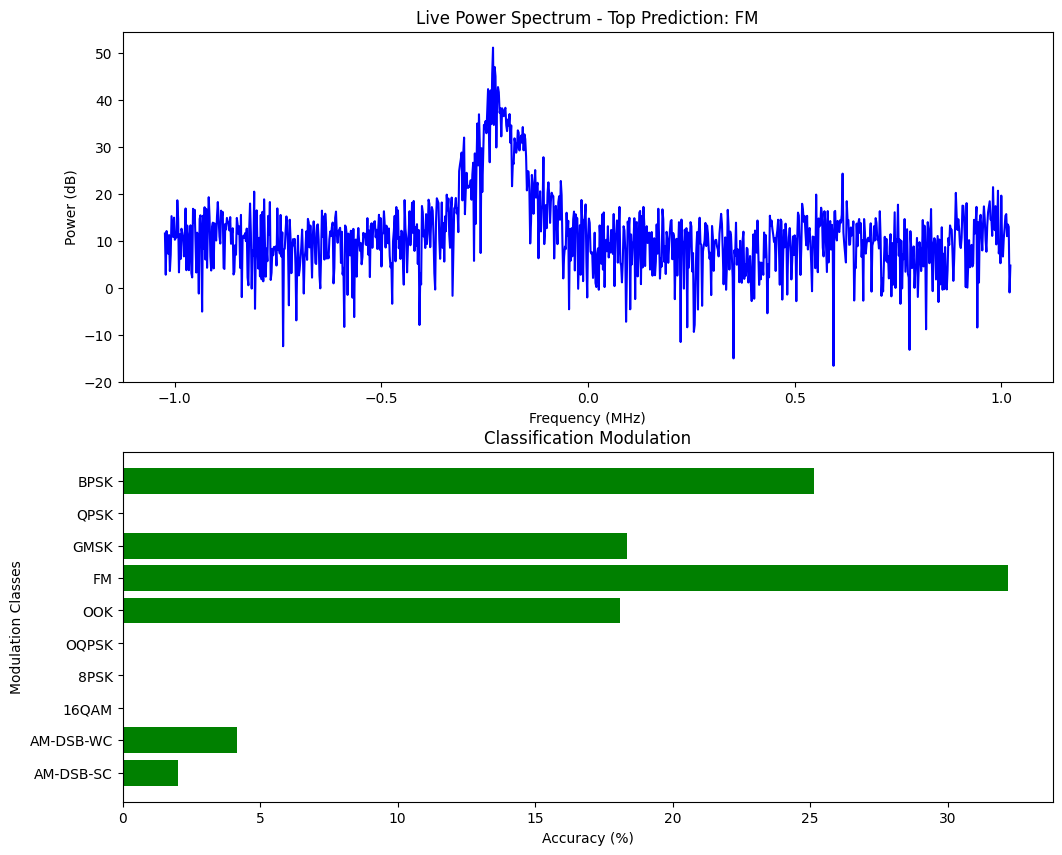

In [ ]:
import numpy as np
import onnxruntime as ort
from rtlsdr import RtlSdr
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy.signal import resample
import collections
import time

# ====================
# Load ONNX Model
# ====================
onnx_filename = "/home/cbeario/DeepPrior/CNN_32_bit.onnx"  # Update path if necessary
ort_session = ort.InferenceSession(onnx_filename)

# ===================
# RTL-SDR Configuration
# ===================
sdr = RtlSdr()
sdr.sample_rate = 2.048e6  # Hz
sdr.center_freq = 95e6    # Hz  (Set center frequency)
sdr.freq_correction = 60   # PPM (Calibration)
sdr.gain = 'auto'         # Auto Gain

# ====================
# Parameters
# ====================
fft_size = 1024  # Length of each sample block
resample_size = 1024  # Resample to match ONNX input size

# ====================
# Class Mapping
# ====================
class_labels = {
    0: "BPSK",
    1: "QPSK",
    2: "GMSK",
    3: "FM",
    4: "OOK",
    5: "OQPSK",
    6: "8PSK",
    7: "16QAM",
    8: "AM-DSB-WC",
    9: "AM-DSB-SC"
}

# ====================
# Track Class Detections
# ====================
class_counts = collections.defaultdict(int)
total_predictions = 0
current_class = "Unknown"  # Store latest predicted class

# ====================
# Initialize Matplotlib Figures
# ====================
fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # Two subplots: Spectrum + Probability Bar Chart

# ====================
# Function to update plots dynamically
# ====================
def update():
    global total_predictions, current_class

    # Read samples from RTL-SDR
    samples = sdr.read_samples(fft_size * 2)
    samples = np.array(samples)  # Convert complex I/Q samples

    # Resample to match model input size
    samples_resampled = resample(samples, resample_size)
    samples_resampled = samples_resampled / np.max(np.abs(samples_resampled))  # Normalize

    # Reshape to ONNX format: (batch, 1024, 1, 2)
    X_input = np.zeros((1, 1024, 1, 2), dtype=np.float32)
    X_input[0, :, 0, 0] = np.real(samples_resampled)  # I-component
    X_input[0, :, 0, 1] = np.imag(samples_resampled)  # Q-component

    # Run inference
    outputs = ort_session.run(None, {"input": X_input})
    probabilities = outputs[0][0]  # Extract probability scores

    # Apply Softmax (optional, depends on model output)
    probabilities = np.exp(probabilities) / np.sum(np.exp(probabilities))

    # Get top 3 predictions
    top_indices = np.argsort(probabilities)[-3:][::-1]
    top_classes = [class_labels[i] for i in top_indices]
    top_probs = [probabilities[i] for i in top_indices]

    # Store top prediction
    current_class = top_classes[0]
    class_counts[top_indices[0]] += 1  # Increase count for highest confidence class
    total_predictions += 1

    print(f"\nPredicted Classes:")
    for i in range(3):
        print(f"  {top_classes[i]}: {top_probs[i]*100:.2f}%")

    # ===========
    # Update Power Spectrum
    # ===========
    spectrum = np.fft.fftshift(np.fft.fft(samples_resampled))
    freqs = np.fft.fftshift(np.fft.fftfreq(fft_size, 1 / sdr.sample_rate))

    axs[0].cla()  # Clear previous frame
    axs[0].plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum) ** 2), color="blue")
    axs[0].set_xlabel("Frequency (MHz)")
    axs[0].set_ylabel("Power (dB)")
    axs[0].set_title(f"Live Power Spectrum - Top Prediction: {current_class}")

    # ===========
    # Update Probability Bar Graph
    # ===========
    class_names = [class_labels[i] for i in range(len(class_labels))]
    detection_counts = [probabilities[i] * 100 for i in range(len(class_labels))]  # Convert to percentage

    axs[1].cla()  # Clear previous frame
    axs[1].barh(class_names, detection_counts, color="green")
    axs[1].set_xlabel("Accuracy (%)")
    axs[1].set_ylabel("Modulation Classes")
    axs[1].set_title("Classification Modulation")
    axs[1].invert_yaxis()  # Highest confidence class at the top

    clear_output(wait=True)  # Prevent flickering
    display(fig)  # Update the figure

# ====================
# Start Real-Time Loop (Jupyter Compatible)
# ====================
print("Starting RTL-SDR signal processing and ONNX inference...")

try:
    while True:
        update()
        time.sleep(0.5)  # Update every 500ms

except KeyboardInterrupt:
    print("\nStopping RTL-SDR and closing inference session.")
    sdr.close()
